In [1]:
%env KMP_DUPLICATE_LIB_OK=TRUE 
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pyhht

from nfmd import NFMD
from utils import compute_hilbert, get_noise

# Pull out common plotting settings:
from plot_params import get_plot_params
full_params, half_params = get_plot_params()
plt.rcParams.update(full_params)

env: KMP_DUPLICATE_LIB_OK=TRUE


In [2]:
# Generate an example signal
fs = 5000
t_max = 1
n = int(fs*t_max)

# Build signal
t = np.linspace(0,t_max,n)
dt = t[1]-t[0]


# Define first periodic mode:
omega_1 = lambda x: 245 + 10*x**2
amp_1 = lambda x: 5 - 0.5*np.exp(-x/3)

z_1 = lambda t: amp_1(t)*np.cos(2*np.pi*omega_1(t)*t)

# Define the mean of the signal:
t0 = 0.3
H1 = np.heaviside(t0-t, 0)
H2 = np.heaviside(t-t0, 1)

mu = lambda x: H1*np.sin(2*x) + H2*2.5*np.cos((x)+np.pi)

# Create signal
z = z_1(t) + mu(t)

# Add noise
noise = get_noise(z, SNR=20)
z += noise


In [3]:
%%time

###############
# Nonstationary Fourier Mode Decomposition
###############

nfmd = NFMD(z/np.std(z),
            num_freqs=2,
            window_size=40,
            optimizer_opts={'lr': 1e-4},
            max_iters=100,
            target_loss=1e-4) # target_loss=5e-4)

freqs, A, losses, indices = nfmd.decompose_signal(500)

0/4961|500/4961|1000/4961|1500/4961|2000/4961|2500/4961|3000/4961|3500/4961|4000/4961|4500/4961|Wall time: 2min 29s


In [4]:
n_freqs = nfmd.correct_frequencies(dt=dt)
n_amps = nfmd.compute_amps()
n_mean = nfmd.compute_mean()

In [5]:
%%time

###############
# Hilbert-Huang Transform
###############

emd = pyhht.emd.EMD(z, t)
imfs = emd.decompose()

imf_results = []
for imf in imfs:
    imf_results.append(compute_hilbert(imf, fs))
    
print(len(imf_results))
mean_imf = imfs[-1]

9
Wall time: 481 ms


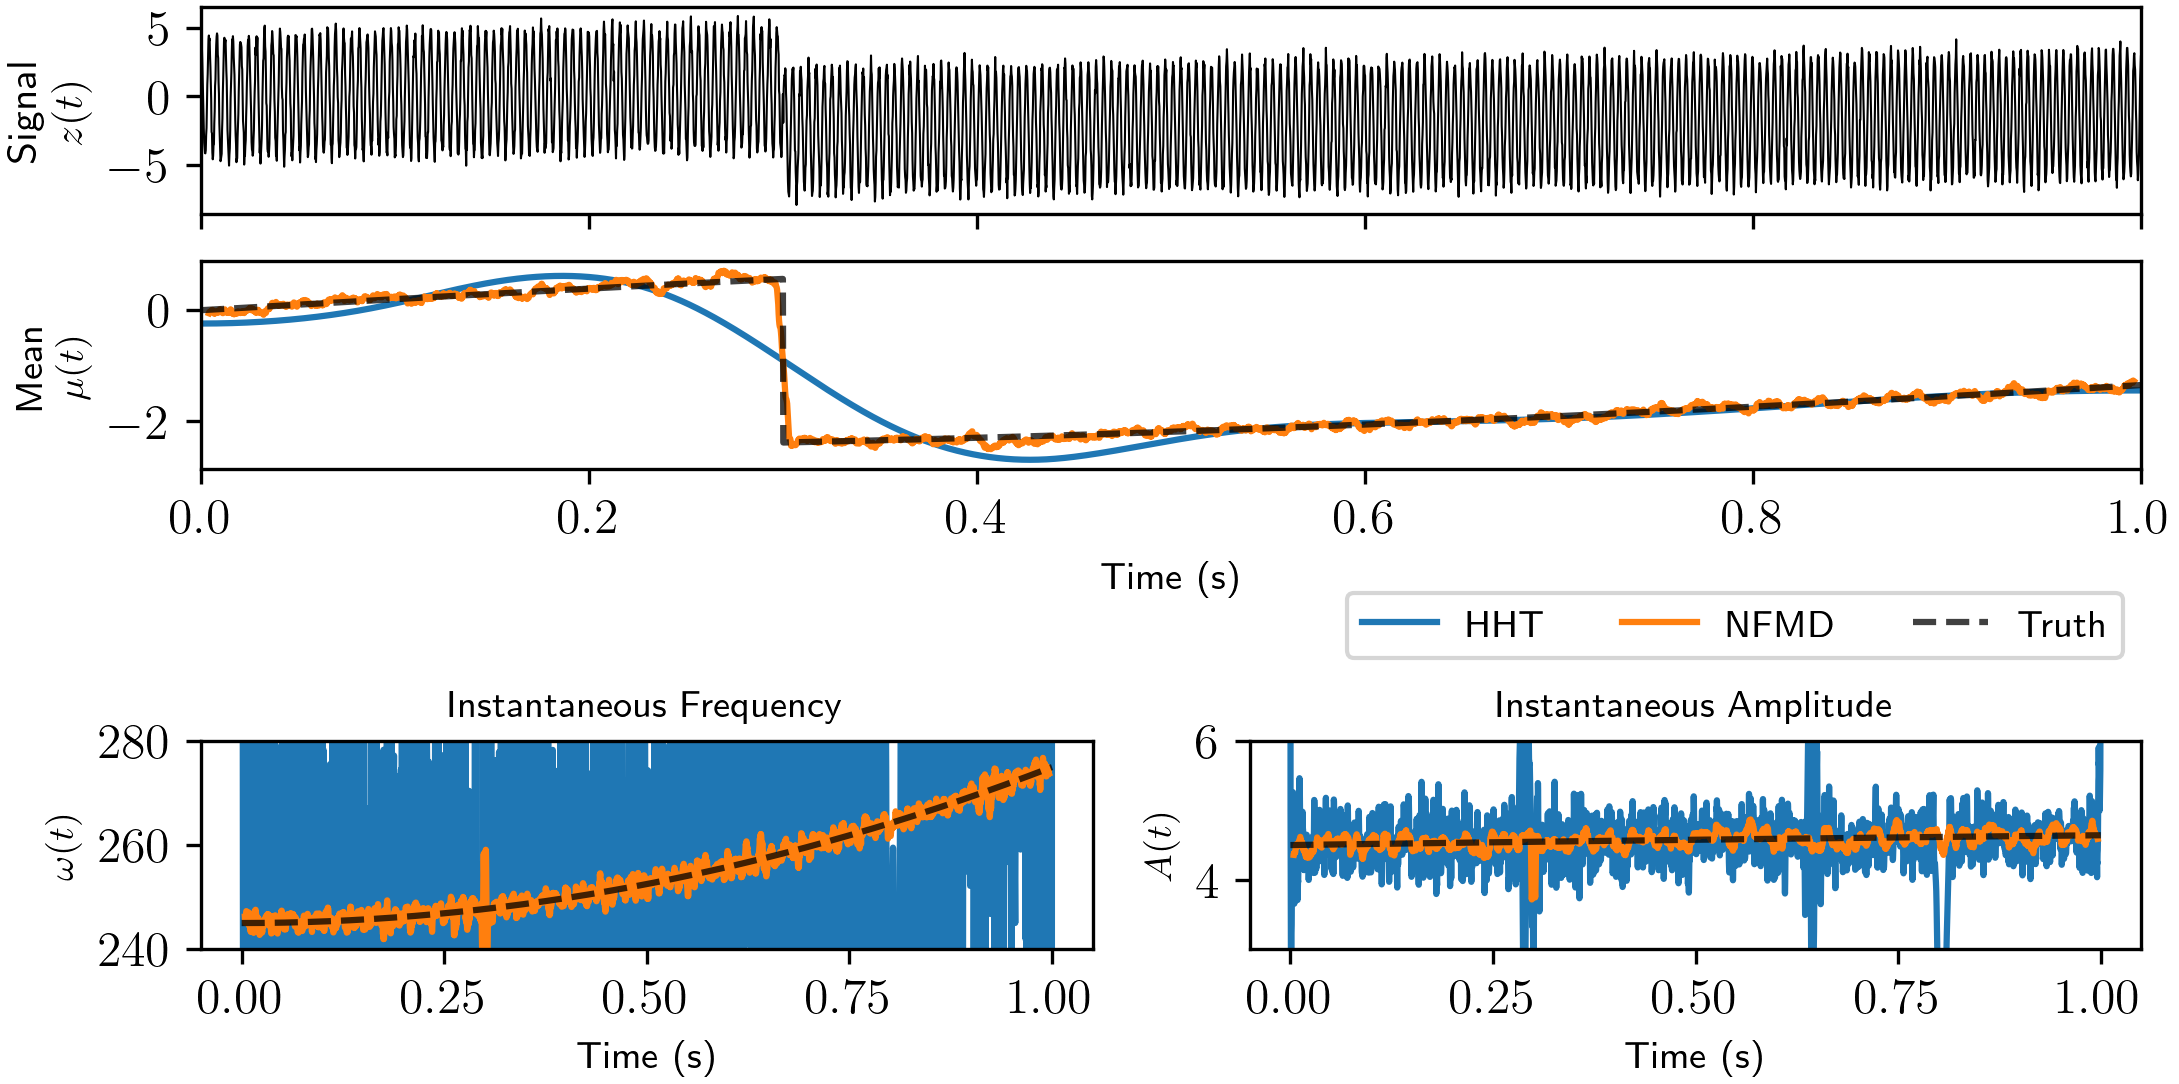

In [6]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(3, 2)

idcs = np.asarray(nfmd.mid_idcs)

color = 'orange'

##############################################
## Axes List 1 -- Top Row -- Signal Example ##
##############################################
ax1 = fig3.add_subplot(gs[0, :])
ax1.plot(t, z, lw=0.5, color='k')
ax1.set_ylabel('Signal\n$z(t)$')

##########################################
## Second row -- Third Mode Comparisons ##
##########################################
ax2 = fig3.add_subplot(gs[1,:], sharex=ax1)

ax2.plot(t, mean_imf, label='HHT')
ax2.plot(t[nfmd.mid_idcs], n_mean*np.std(z), label='NFMD')
ax2.plot(t, mu(t), '--k', label='Truth', alpha=0.75)

ax2.legend(bbox_to_anchor=(1,-0.75), loc='right', ncol=3, fontsize=9)
ax2.set_ylabel('Mean\n$\mu(t)$', fontsize=9)
ax2.set_xlabel('Time (s)', fontsize=9)
ax2.set_xlim([0,1])


# Set up lower axes
ax4a = fig3.add_subplot(gs[2,0])
ax4b = fig3.add_subplot(gs[2,1])

# Hide higher axis xlabels
plt.setp(ax1.get_xticklabels(), visible=False)

# Put titles on the 3a and 3b columns
ax4a.set_title('Instantaneous Frequency', fontsize=9)
ax4b.set_title('Instantaneous Amplitude', fontsize=9)


##########################################
## Third row -- Second Mode Comparisons ##
##########################################
f_idx = 0
emd_idx = 1

ax4a.plot(t, imf_results[emd_idx][1])
ax4a.plot(t[nfmd.mid_idcs], n_freqs[:,f_idx])
ax4a.plot(t, np.gradient(omega_1(t)*t, dt), '--k', alpha=0.75)

ax4b.plot(t, imf_results[emd_idx][3])
ax4b.plot(t[nfmd.mid_idcs], n_amps[:,f_idx]*np.std(z))
ax4b.plot(t, amp_1(t), '--k', alpha=0.75)

# Format axes
ax4a.set_ylabel(r"$\omega(t)$", fontsize=9)
ax4b.set_ylabel('$A(t)$', fontsize=9)
ax4a.set_xlabel('Time (s)', fontsize=9)
ax4b.set_xlabel('Time (s)', fontsize=9)

ax4a.set_ylim([240,280])
ax4b.set_ylim([3,6])
# Final adjustments
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

plt.savefig("shea7.png")

plt.show()